In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/TCC/multiclass-dataset.zip

In [ ]:
!mkdir ndataset
!mkdir ndataset/malignant
!mkdir ndataset/benign
!mkdir ndataset/normal

In [ ]:
import os
from PIL import Image

dataset_dir = 'dataset'
ndataset_dir = 'ndataset'

for class_name in ['malignant', 'benign', 'normal']:
    class_dir = os.path.join(ndataset_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                new_image = image.resize((224, 224))
                save_dir = os.path.join(ndataset_dir, class_name)
                save_path = os.path.join(save_dir, image_file)
                new_image.save(save_path)

In [ ]:
directory = '/content/ndataset'

categories = ['benign', 'malignant', 'normal']

In [ ]:
import cv2
import random
import os
import numpy as np
from collections import Counter

data = []
img_size = 224

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)
X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)

X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

In [ ]:
from keras.models import Sequential
from keras.applications.xception import Xception

X_train_rgb = np.repeat(X_train, 3, axis=3)
X_valid_rgb = np.repeat(X_valid, 3, axis=3)

base_model = Xception(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(16))
model.add(layers.Rescaling(1.0 / 255))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 rescaling_1 (Rescaling)     (None, 16)                0         
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 batch_normalization_5 (Batc  (None, 16)               

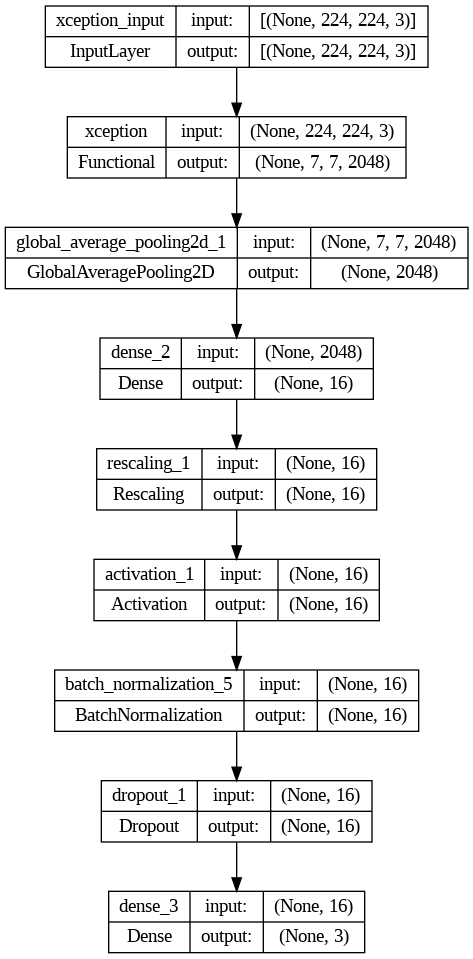

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_rgb, y_train, batch_size=8, epochs=20, validation_data=(X_valid_rgb, y_valid))

Epoch 1/20
103/103 [==============================] - 57s 161ms/step - loss: 1.0722 - accuracy: 0.5900 - val_loss: 1.0956 - val_accuracy: 0.5782
Epoch 2/20
103/103 [==============================] - 14s 132ms/step - loss: 0.9994 - accuracy: 0.7689 - val_loss: 1.0848 - val_accuracy: 0.7636
Epoch 3/20
103/103 [==============================] - 14s 134ms/step - loss: 0.9059 - accuracy: 0.8041 - val_loss: 1.0592 - val_accuracy: 0.8255
Epoch 4/20
103/103 [==============================] - 14s 136ms/step - loss: 0.8189 - accuracy: 0.8297 - val_loss: 1.0088 - val_accuracy: 0.8509
Epoch 5/20
103/103 [==============================] - 14s 138ms/step - loss: 0.7536 - accuracy: 0.8273 - val_loss: 0.9232 - val_accuracy: 0.8655
Epoch 6/20
103/103 [==============================] - 14s 138ms/step - loss: 0.6947 - accuracy: 0.8382 - val_loss: 0.7977 - val_accuracy: 0.8691
Epoch 7/20
103/103 [==============================] - 14s 137ms/step - loss: 0.6643 - accuracy: 0.8528 - val_loss: 0.6624 - val_ac

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_valid_rgb, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 4s 246ms/step
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.99      1.00      1.00       141
           2       0.97      1.00      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.96      0.97       275
weighted avg       0.99      0.99      0.99       275

[[ 26   1   3]
 [  0 141   0]
 [  0   0 104]]


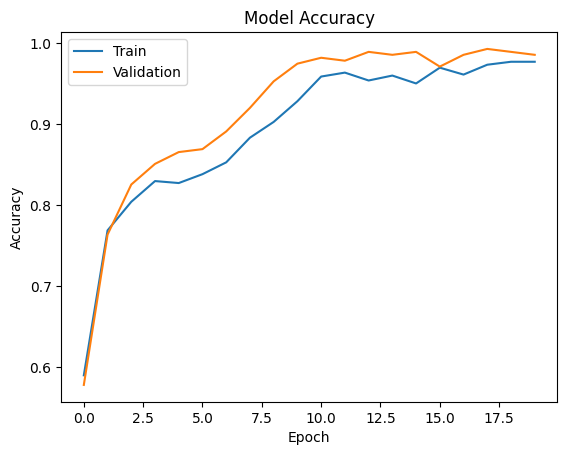

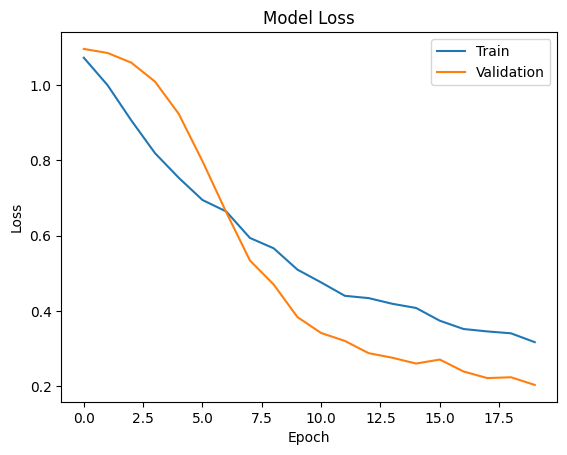

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()